In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
worksheet = gc.open('xmm_with_redshift').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

index = [i[0] for i in rows[1:]]
adjusted_rows = [i[1:] for i in rows[1:]]

import pandas as pd
df = pd.DataFrame.from_records(adjusted_rows, columns=rows[0][1:], index=index)

df.head()

SC_RA        SC_DEC SC_EP_8_FLUX SC_EP_8_FLUX_ERR  \
207009901010024  0.006905748378   68.13455524     2.89E-14         8.30E-15   
201253101010057  0.007534431099  -25.28516856     1.79E-14         1.35E-14   
206584004010022   0.00871585155    44.5149709     2.56E-14         1.06E-14   
203025805010017   0.01007083288  -32.25863789     1.91E-14         3.96E-15   
201253101010009    0.0112696999  -25.19337615     7.40E-14         1.33E-14   

                              objID     RAJ2000       DEJ2000     gmag  \
207009901010024  189760000053982249  0.00535066   68.13450866            
201253101010057   77650000066568040  0.00666557  -25.28524502  21.3264   
206584004010022  161410000079588615  0.00789686   44.51494177  19.6866   
203025805010017   69290000106580013  0.01062854  -32.25865907            
201253101010009   77760000111487954   0.0111867  -25.19365618  21.6948   

                 e_gmag     rmag  ...   W2mag   W3mag  W4mag e_W1mag e_W2mag  \
207009901010024                   ...  14.485  11.595  8.903    0.04   0.065   
201253101010057  0.0372  20.9832  ...  16.382  12.454  9.144   0.141   0.361   
206584004010022  0.0137  19.4907  ...  15.175  11.587   8.89   0.052   0.083   
203025805010017                   ...  15.038  12.265  8.723   0.064   0.101   
201253101010009  0.0807   21.372  ...                                          

                e_W3mag e_W4mag nbref  main_type zsp  
207009901010024   0.241    0.44                       
201253101010057                                       
206584004010022   0.136                               
203025805010017   0.385                               
201253101010009                     6  Seyfert_1      

[5 rows x 35 columns]

In [ ]:
import numpy as np
df = df.replace('',np.nan)
for i in range(len(df.columns)):
  try:
    df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric)
  except:
    print(i)
    pass

33


In [ ]:
print(df.zsp.max(), df.zsp.min())
#It is now 13.721 Gyr since the Big Bang.
#The age at redshift z was 0.769 Gyr.
#The light travel time was 12.952 Gyr.

7.01124 -0.00414


In [ ]:
def is_AGN(x):
  value = "Unknown"
  if x.main_type in ["QSO", "Seyfert_1", "Seyfert_2", "BLLac", "Blazar", "RadioG", "AGN"] and x.nbref>=3:
    return True
  elif x.parallax/x.parallax_error > 3 or x.pmra/x.pmra_error>3 or x.pmdec/x.pmdec_error>3:
    return False
  elif pd.isna(x.main_type):
    return value
  elif x.nbref<3 or "Candidate" in x.main_type:
    return value
  else:
    return False

df["is_AGN"] = df.apply(lambda x: is_AGN(x), axis=1)
df.is_AGN.value_counts()

Unknown    153056
False       45000
True        23068
Name: is_AGN, dtype: int64

In [ ]:
def classifier(x):
  if x.parallax/x.parallax_error > 3 or x.pmra/x.pmra_error>3 or x.pmdec/x.pmdec_error>3:
    return 0
  elif x.parallax/x.parallax_error > 1 or x.pmra/x.pmra_error>1 or x.pmdec/x.pmdec_error>1:
    return 1
  else:
    return 2

df["classification"] = df.apply(lambda x: classifier(x), axis=1)
df.classification.value_counts()

2    158622
0     40847
1     21655
Name: classification, dtype: int64

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df["log_flux"] = np.log10(df["SC_EP_8_FLUX"])
input_labels = ['gmag', 'ymag','rmag', "zmag", 'imag', "W1mag", "W2mag", "W3mag", "W4mag", "log_flux", "is_AGN", "classification"]
known_df = df[df["is_AGN"] != "Unknown"]
input_df = known_df[input_labels].dropna()
y = input_df["is_AGN"].astype(int)
X = input_df.drop("is_AGN", axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
def model_stats(y_test, y_pred):
  print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
  print("Precision: ", metrics.precision_score(y_test, y_pred))
  print("Recall: ", metrics.recall_score(y_test, y_pred))

In [ ]:
Regression_model = RandomForestClassifier(n_estimators = 500, min_samples_split=8)
Regression_model.fit(X_train, y_train)

y_pred = Regression_model.predict(X_test)
model_stats(y_test, y_pred)

Accuracy:  0.967965549837202
Precision:  0.942753143613501
Recall:  0.955719557195572


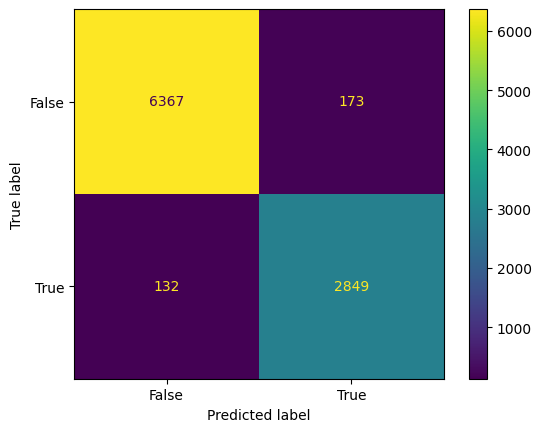

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

[Text(0, 0.5, 'W1-W2'), Text(0.5, 1.0, 'Predicted dataset')]

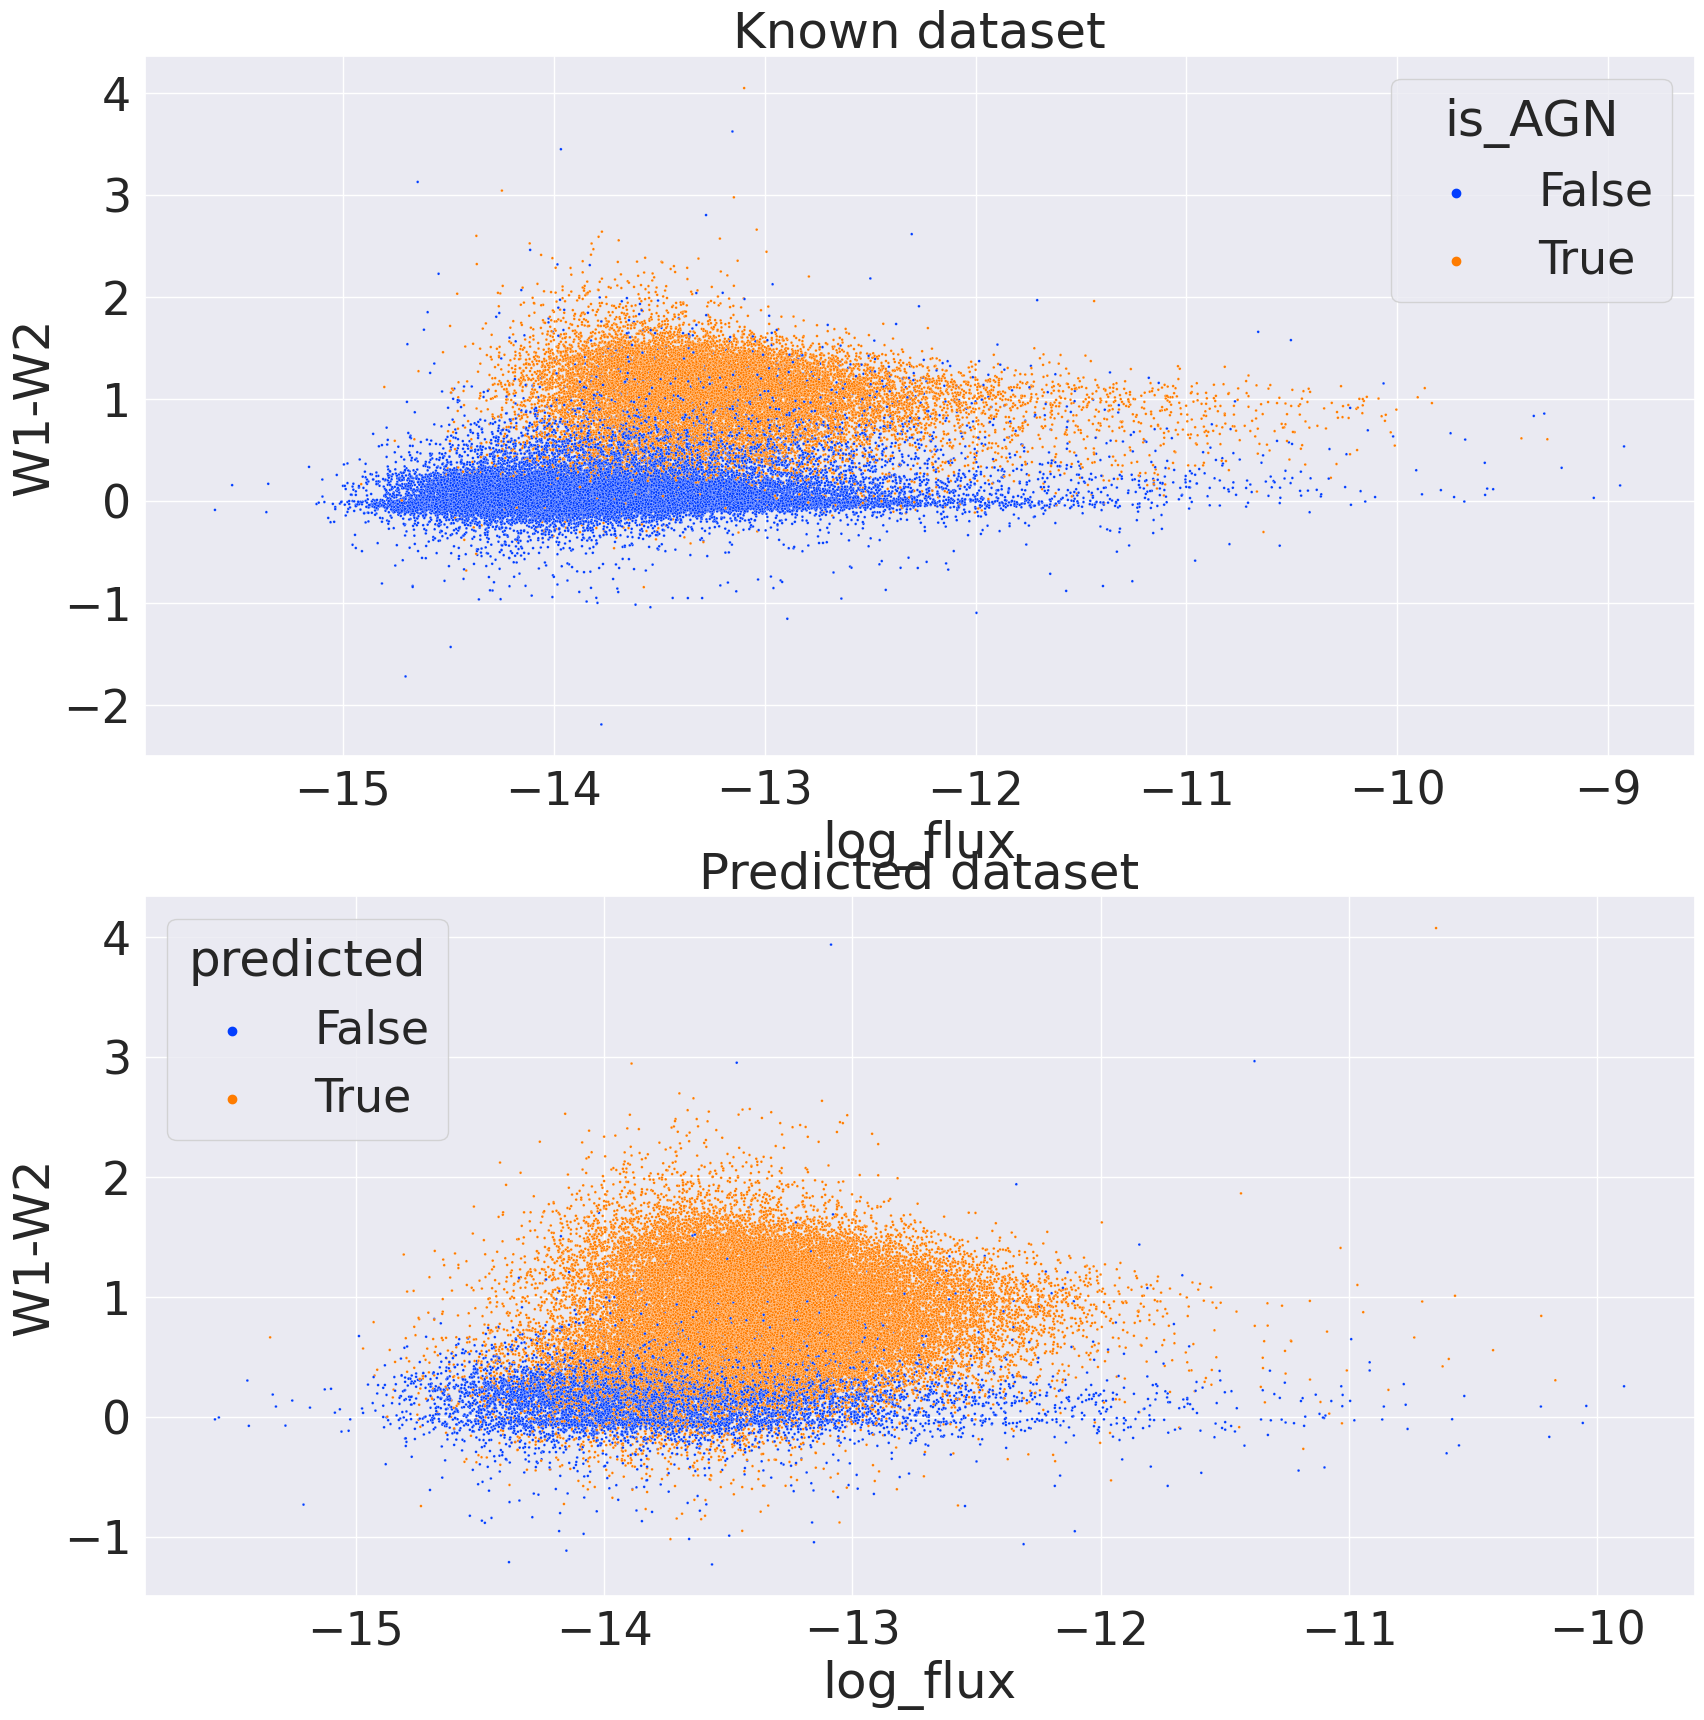

In [ ]:
unknown_df = df[df["is_AGN"] == "Unknown"]
unknown_df = unknown_df[input_labels]
unknown_df = unknown_df.drop("is_AGN", axis=1)
unknown_df =unknown_df.dropna()
predicted = Regression_model.predict(unknown_df)
unknown_df["predicted"] = predicted
sns.set(font_scale=3)

fig, ax =plt.subplots(2,1, figsize = (20,20))
plot1 = sns.scatterplot(x=known_df["log_flux"], y = (known_df["W1mag"]-known_df["W2mag"]), hue=known_df["is_AGN"], palette="bright", ax=ax[0], s=4)
plot1.set(ylabel= "W1-W2", title = "Known dataset")
plot2 = sns.scatterplot(x=unknown_df["log_flux"], y = (unknown_df["W1mag"]-unknown_df["W2mag"]), hue=unknown_df["predicted"].astype(bool), palette="bright", ax=ax[1], s=4)
plot2.set(ylabel= "W1-W2", title = "Predicted dataset")

[Text(0, 0.5, 'g-r'), Text(0.5, 1.0, 'Predicted dataset')]

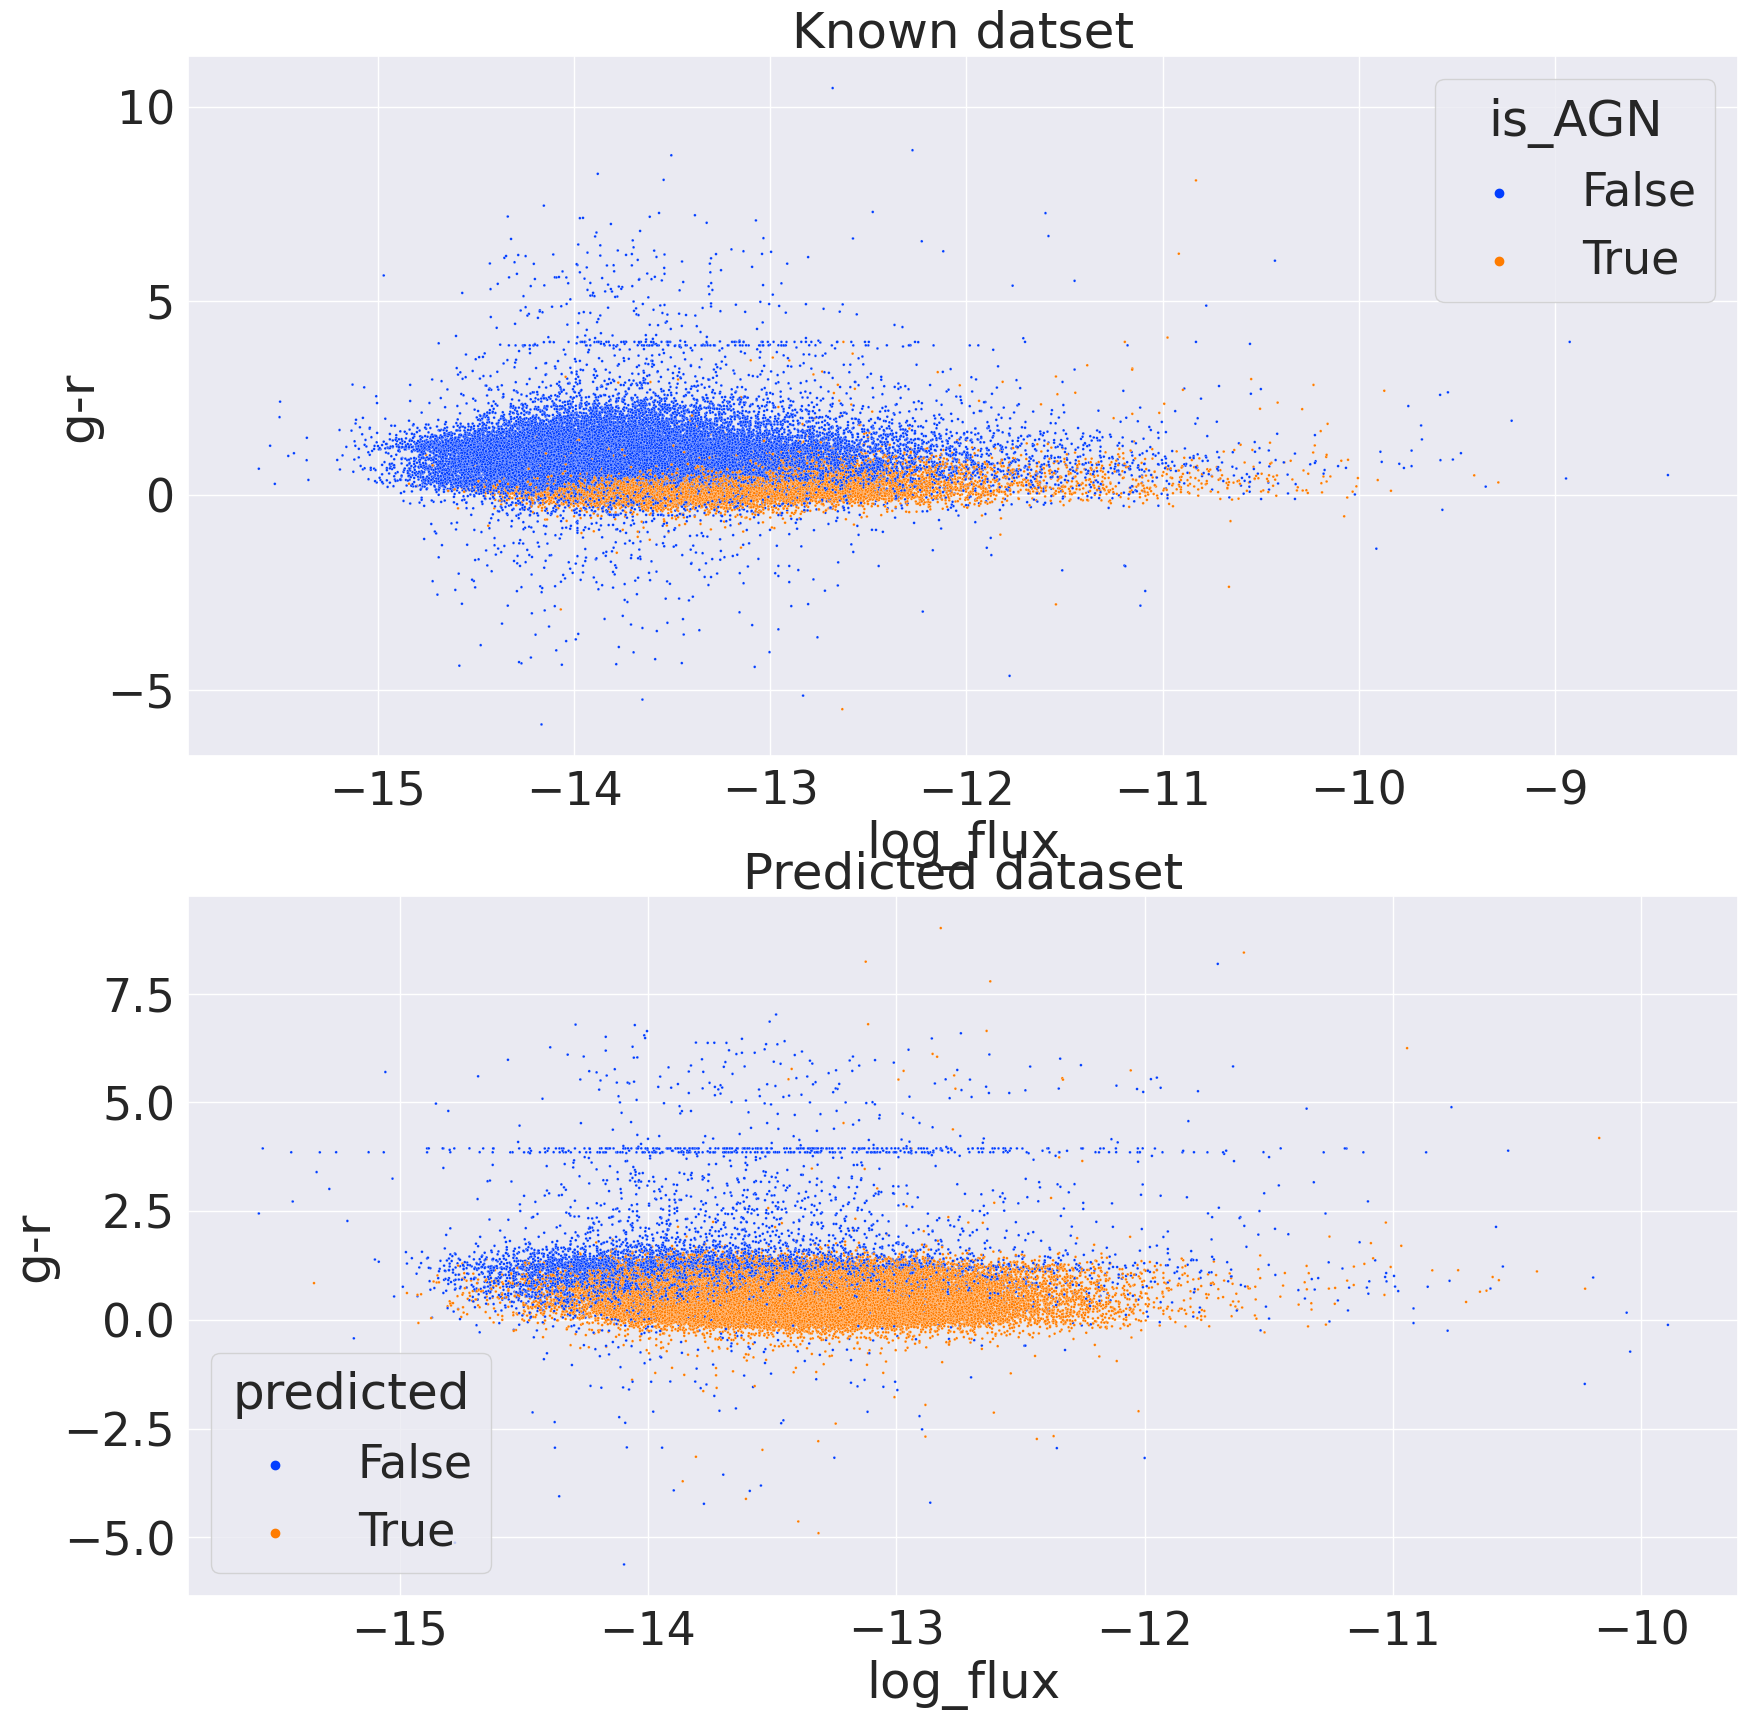

In [ ]:
fig, ax =plt.subplots(2,1, figsize = (20,20))
plot1 = sns.scatterplot(x=known_df["log_flux"], y = (known_df["gmag"]-known_df["rmag"]), hue=known_df["is_AGN"], palette="bright", ax=ax[0], s=4)
plot1.set(ylabel= "g-r", title = "Known datset")
plot2 = sns.scatterplot(x=unknown_df["log_flux"], y = (unknown_df["gmag"]-unknown_df["rmag"]), hue=unknown_df["predicted"].astype(bool), palette="bright", ax=ax[1], s=4)
plot2.set(ylabel= "g-r", title = "Predicted dataset")

In [ ]:
metrics_dic = {"samples":[],"estimators":[],"accuracy":[]}
for estimators in range(100,1000, 100):
  for samples in range(2,10):
    forest = RandomForestClassifier(n_estimators = estimators, min_samples_split = samples).fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    metrics_dic["samples"].append(samples)
    metrics_dic["estimators"].append(estimators)
    metrics_dic["accuracy"].append(metrics.accuracy_score(y_test, y_pred))

metrics_df=pd.DataFrame(metrics_dic)

<Axes: xlabel='estimators', ylabel='smooth_accuracy'>

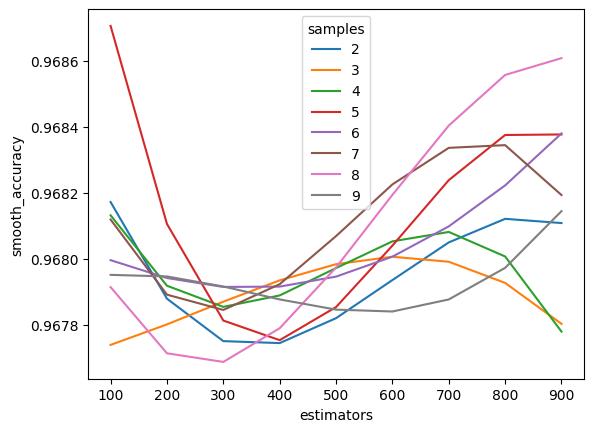

In [ ]:
from scipy import interpolate
metrics_df["smooth_accuracy"] = 0
for i in metrics_df.samples.unique():
  spline = interpolate.UnivariateSpline(metrics_df[metrics_df.samples == i]["estimators"],metrics_df[metrics_df.samples == i]["accuracy"])
  metrics_df.loc[metrics_df.samples == i, "smooth_accuracy"] = spline(metrics_df.loc[metrics_df.samples == i, "estimators"])

sns.lineplot(data = metrics_df, x="estimators", y= "smooth_accuracy", hue = metrics_df["samples"].astype(str))

In [ ]:
known_df = df[df["is_AGN"] != "Unknown"]
known_df = known_df[input_labels]
y = known_df["is_AGN"].astype(int)
X = known_df.drop("is_AGN", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = HistGradientBoostingClassifier(early_stopping = True, learning_rate = 0.0111, max_iter = 700, max_leaf_nodes = 41)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(early_stopping=True, learning_rate=0.0111,
                               max_iter=700, max_leaf_nodes=41)

In [ ]:
y_pred = model.predict(X_test)

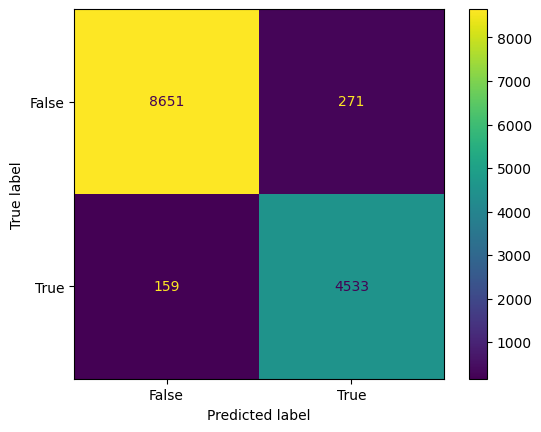

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
model_stats(y_test, y_pred)

Accuracy:  0.9684148670486264
Precision:  0.9435886761032473
Recall:  0.9661125319693095


[Text(0, 0.5, 'W1-W2'), Text(0.5, 1.0, 'Predicted dataset')]

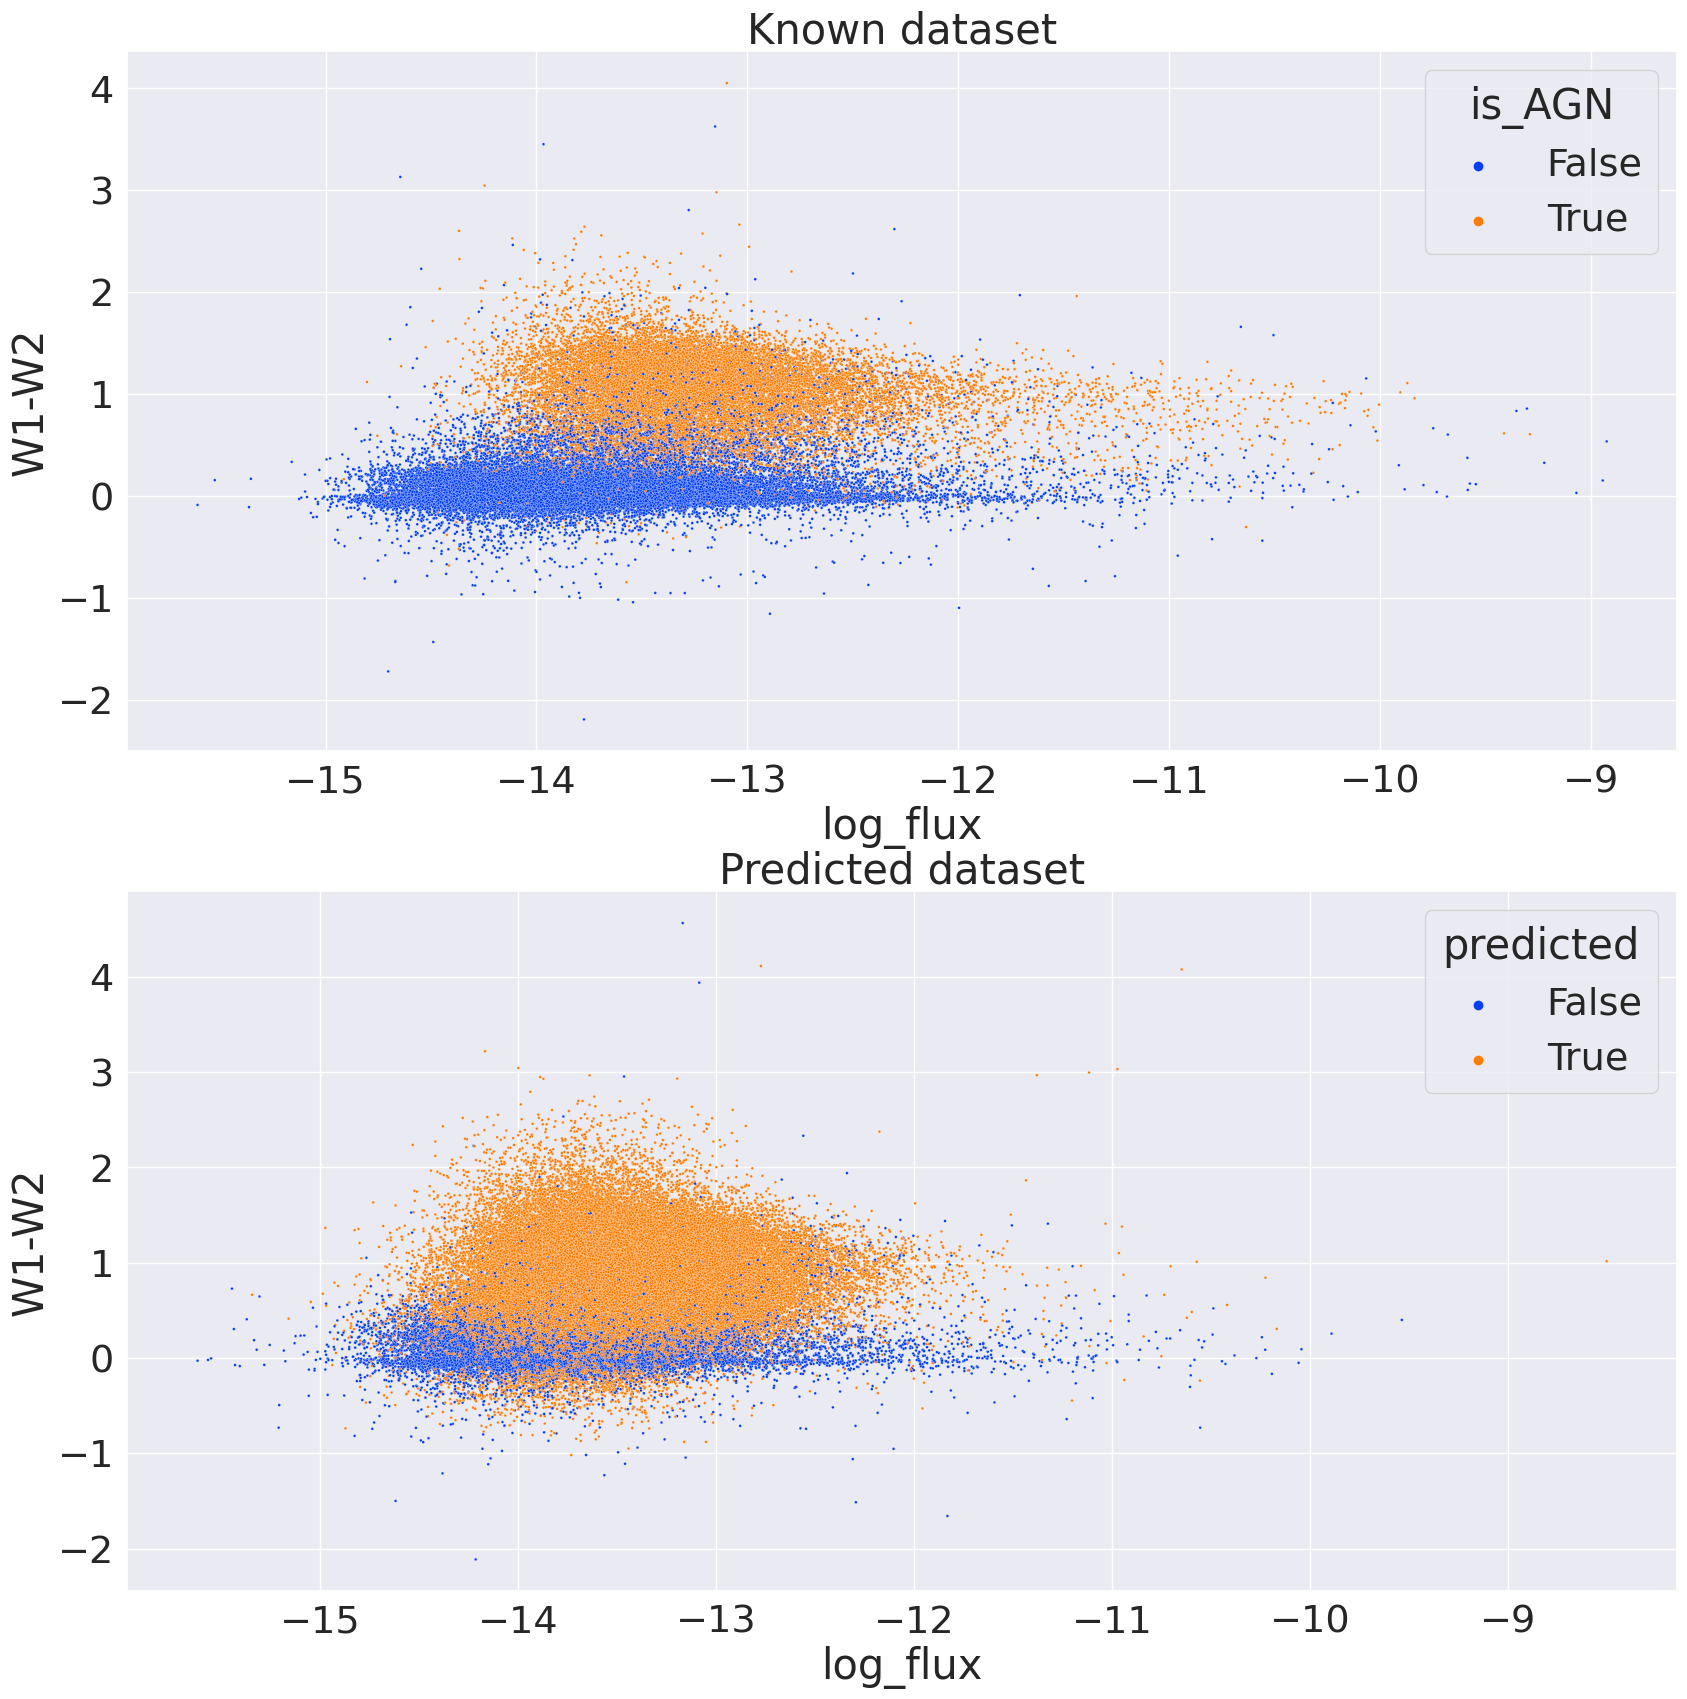

In [ ]:
unknown_df = df[df["is_AGN"] == "Unknown"]
unknown_df = unknown_df[input_labels]
unknown_df = unknown_df.drop("is_AGN", axis=1)
predicted = model.predict(unknown_df)
unknown_df["predicted"] = predicted
sns.set(font_scale=2.5)

fig, ax =plt.subplots(2,1, figsize = (20,20))
plot1 = sns.scatterplot(x=known_df["log_flux"], y = (known_df["W1mag"]-known_df["W2mag"]), hue=known_df["is_AGN"], palette="bright", ax=ax[0], s=4)
plot1.set(ylabel= "W1-W2", title = "Known dataset")
plot2 = sns.scatterplot(x=unknown_df["log_flux"], y = (unknown_df["W1mag"]-unknown_df["W2mag"]), hue=unknown_df["predicted"].astype(bool), palette="bright", ax=ax[1], s=4)
plot2.set(ylabel= "W1-W2", title = "Predicted dataset")

[Text(0, 0.5, 'g-r'), Text(0.5, 1.0, 'Predicted dataset')]

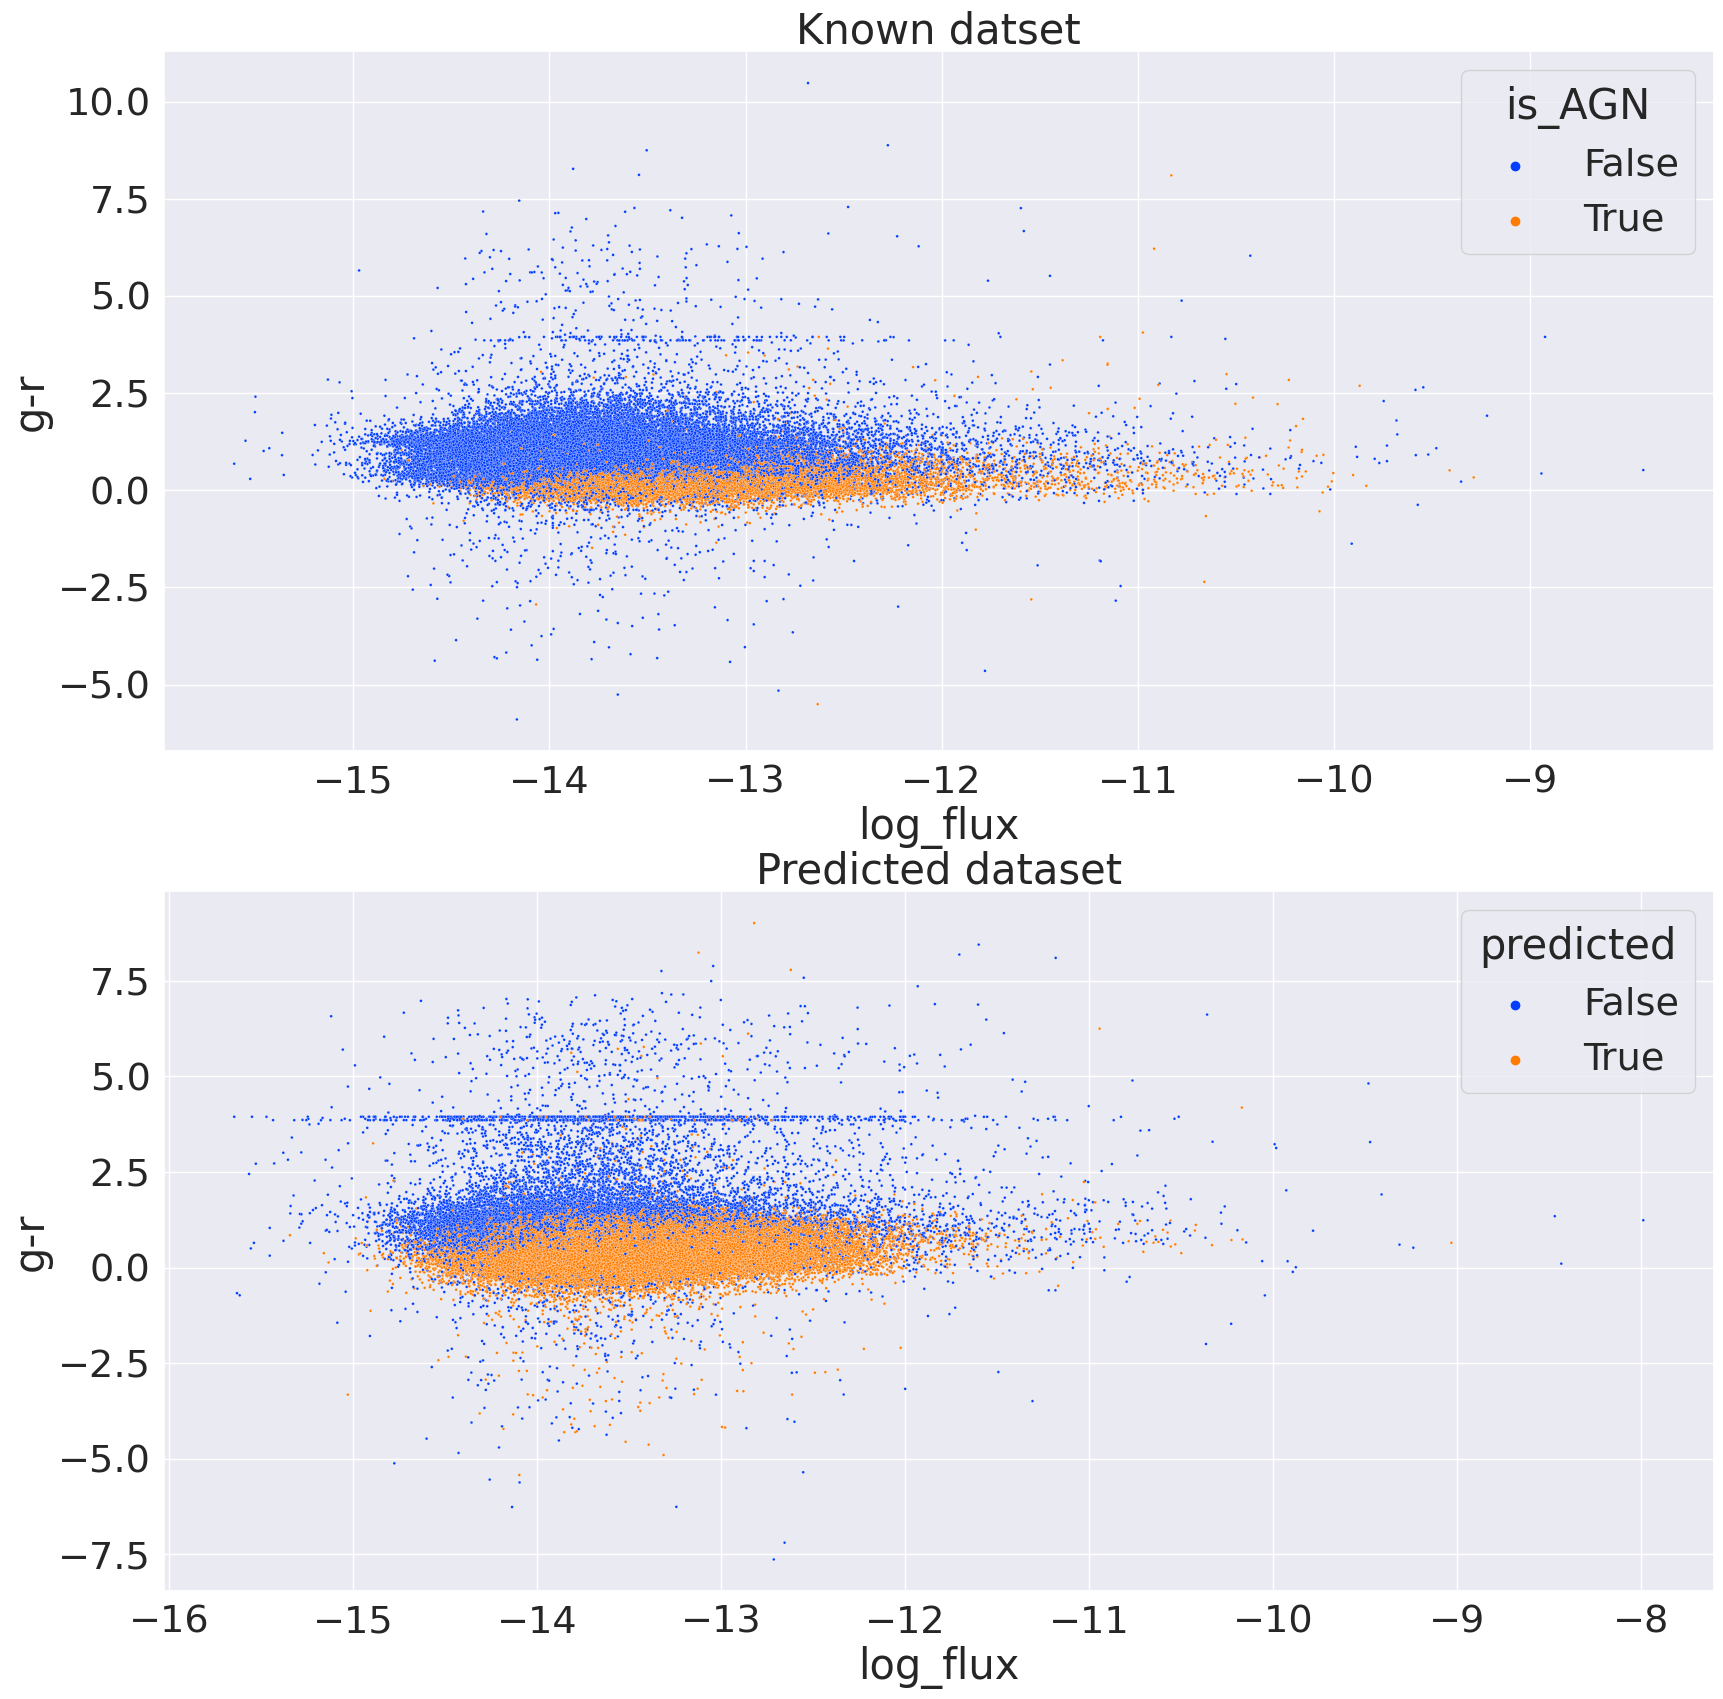

In [ ]:
fig, ax =plt.subplots(2,1, figsize = (20,20))
plot1 = sns.scatterplot(x=known_df["log_flux"], y = (known_df["gmag"]-known_df["rmag"]), hue=known_df["is_AGN"], palette="bright", ax=ax[0], s=4)
plot1.set(ylabel= "g-r", title = "Known datset")
plot2 = sns.scatterplot(x=unknown_df["log_flux"], y = (unknown_df["gmag"]-unknown_df["rmag"]), hue=unknown_df["predicted"].astype(bool), palette="bright", ax=ax[1], s=4)
plot2.set(ylabel= "g-r", title = "Predicted dataset")

<Axes: xlabel='log_flux', ylabel='Count'>

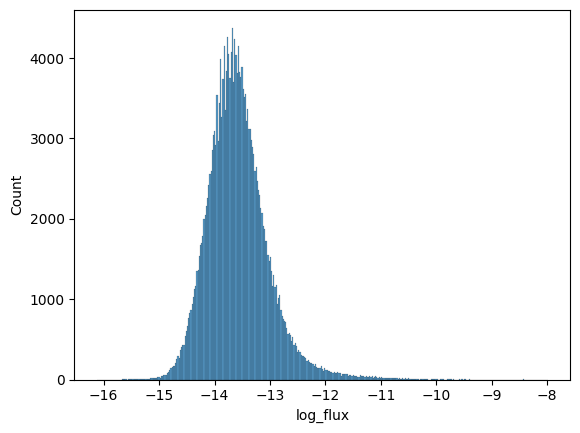

In [ ]:
sns.histplot(data = df, x="log_flux")

<Axes: xlabel='W1mag', ylabel='Count'>

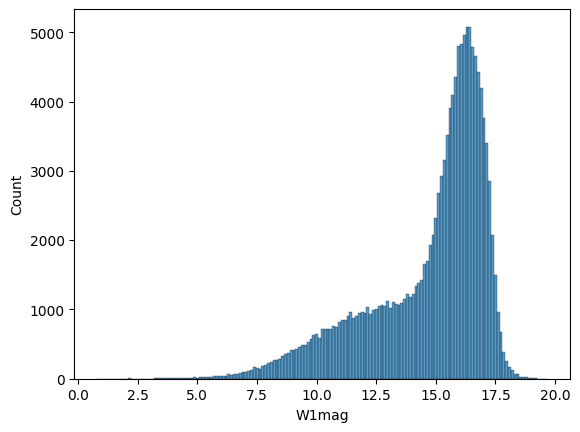

In [ ]:
sns.histplot(data = df, x="W1mag")

In [ ]:
metrics_dic = {"rate":[],"iter":[],"accuracy":[]}
for rate in np.linspace(0.001,1,100):
  for iter in range(100,1000,100):
    Hist_tree = HistGradientBoostingClassifier(early_stopping = True, learning_rate = rate, max_iter = iter).fit(X_train, y_train)
    y_pred = Hist_tree.predict(X_test)
    metrics_dic["rate"].append(rate)
    metrics_dic["iter"].append(iter)
    metrics_dic["accuracy"].append(metrics.accuracy_score(y_test, y_pred))

metrics_df=pd.DataFrame(metrics_dic)

<Axes: xlabel='rate', ylabel='smooth_accuracy'>

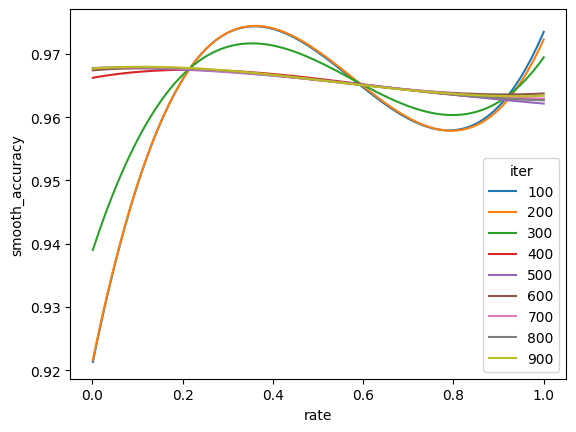

In [ ]:
metrics_df["smooth_accuracy"] = 0
for i in metrics_df.iter.unique():
  spline = interpolate.UnivariateSpline(metrics_df[metrics_df.iter == i]["rate"],metrics_df[metrics_df.iter == i]["accuracy"])
  metrics_df.loc[metrics_df.iter == i, "smooth_accuracy"] = spline(metrics_df.loc[metrics_df.iter == i, "rate"])

sns.lineplot(data = metrics_df, x="rate", y= "smooth_accuracy", hue = metrics_df["iter"].astype(str))

In [ ]:
red_df = df[~df.zsp.isnull()]
red_df = red_df[red_df.is_AGN=="Unknown"]
red_df = red_df.drop("is_AGN", axis=1)
red_df["predicted"] = model.predict(red_df[['gmag', 'ymag','rmag', "zmag", 'imag', "W1mag", "W2mag", "W3mag", "W4mag", "log_flux", "classification"]]).astype(bool)
red_df.head()

SC_RA    SC_DEC  SC_EP_8_FLUX  SC_EP_8_FLUX_ERR  \
206532902010055  0.614148 -2.070533  3.020000e-14      1.610000e-14   
206532901010043  0.656097 -1.627473  3.960000e-14      1.980000e-14   
206532901010019  0.763135 -1.705597  2.950000e-14      8.390000e-15   
206532901010017  0.765083 -1.895956  2.160000e-14      4.250000e-15   
206532902010089  0.787770 -2.067523  1.670000e-15      1.890000e-15   

                        objID   RAJ2000   DEJ2000     gmag  e_gmag     rmag  \
206532902010055  1.055100e+17  0.613870 -2.070375  21.6185  0.1776  21.7305   
206532901010043  1.060400e+17  0.656270 -1.627502  22.1043  0.1747      NaN   
206532901010019  1.059500e+17  0.763645 -1.705607  21.6546  0.1857      NaN   
206532901010017  1.057200e+17  0.765234 -1.895912      NaN     NaN  21.9236   
206532902010089  1.055100e+17  0.787589 -2.067906      NaN     NaN      NaN   

                 ...  e_W1mag  e_W2mag  e_W3mag  e_W4mag  nbref  main_type  \
206532902010055  ...    0.169    0.462      NaN      NaN    NaN        NaN   
206532901010043  ...    0.134    0.189      NaN      NaN    NaN        NaN   
206532901010019  ...      NaN      NaN      NaN      NaN    NaN        NaN   
206532901010017  ...      NaN      NaN      NaN      NaN    1.0        QSO   
206532902010089  ...      NaN      NaN      NaN      NaN    NaN        NaN   

                     zsp  classification   log_flux  predicted  
206532902010055  0.83635               2 -13.519993       True  
206532901010043  0.80219               2 -13.402305       True  
206532901010019  1.06308               2 -13.530178       True  
206532901010017  1.32616               2 -13.665546       True  
206532902010089  0.92854               2 -14.777284       True  

[5 rows x 38 columns]